In [1]:
import librosa
import numpy as np
from scipy.signal import get_window
import scipy.fftpack as fft
import matplotlib.pyplot as plt

import scipy.io
from tqdm import tqdm
from python_speech_features import logfbank


In [28]:
def wav_to_list(wav_files):
    audio_list = np.zeros(len(wav_files))
    for ind,filename in enumerate(wav_files):
        audio, sample_rate = librosa.load(filename)
        audio_list[ind] = audio
    return audio_list

audio, sample_rate = librosa.load('sa1.wav')

In [29]:
print(audio)
print(sample_rate)
print(len(audio))

[ 2.9922800e-05 -2.2494769e-05 -1.7128708e-06 ... -2.3044803e-04
 -2.0874187e-04  0.0000000e+00]
22050
64493


In [2]:
def all_mfsc(sound_list, s_rate_list, hop_size, timeframes, freq_bins):
    n_sounds = len(sound_list)
    all_results = n_sounds*[None]
    for i in tqdm(range(n_sounds)):
        all_results[i] = one_mfsc(sound_list[i],s_rate_list[i], hop_size, timeframes, freq_bins)
        #duration = len(sound_list[i])/s_rate_list[i]
        #winstep = duration/timeframes
        #all_results[i] = logfbank(sound_list[i] , samplerate = s_rate_list[i] , 
        #                          winlen = winstep, winstep = winstep, nfilt=freq_bins, nfft=1024)
    return all_results

#I have kept the below function as a back-up. It is a custom mfsc version.
def one_mfsc(sound, s_rate, hop_size, timeframes, freq_bins):
    sound = sound / np.max(np.abs(sound)) #First, we normalize
    frames, fft_len = create_frames(sound, timeframes, s_rate, hop_size)
    window = get_window("hann", fft_len, fftbins=True)
    windowed = frames * window
    windowedT = windowed.T
    fft_sound= np.empty((int(1 + fft_len // 2), windowedT.shape[1]), dtype=np.complex64, order='F')

    for n in range(fft_sound.shape[1]):
        fft_sound[:, n] = fft.fft(windowedT[:, n], axis=0)[:fft_sound.shape[0]]

    fft_soundT = fft_sound.T
    sound_strength = np.square(np.abs(fft_soundT))

    lowf = 0
    highf = s_rate / 2
    
    filt_places, m_freqs = get_filt_places(lowf, highf, freq_bins, fft_len, s_rate)
    filters = make_filters(filt_places, fft_len)
    
    e_val = 2.0 / (m_freqs[2:freq_bins+2] - m_freqs[:freq_bins])
    filters *= e_val[:, np.newaxis]
    
    sound_filt = np.dot(filters, np.transpose(sound_strength))
    sound_log = 10.0 * np.log10(sound_filt)
    
    return sound_log

def create_frames(sound, n_frames, s_rate, hop_size):
    frame_len = int(len(sound)/(n_frames-1))
    FFT_size = frame_len + (len(sound)/(n_frames-1))#This is the new calculated version
    FFT_size = int(FFT_size/2)*2
    sound = np.pad(sound, int(FFT_size / 2), mode='reflect')
    frames = np.zeros((n_frames, FFT_size))
    for n in range(n_frames):
        frames[n] = sound[n*frame_len:n*frame_len+FFT_size]
        
    return frames, FFT_size

def f_mel(f): #Converts F to Mel
    return 2595.0 * np.log10(1.0 + f / 700.0)

def mel_f(mel): #Converts Mel to F
    return 700.0 * (10.0**(mel / 2595.0) - 1.0)

def get_filt_places(lowF, highF, n_samples, fft_len, s_rate):
    lowf_mel = f_mel(lowF)
    highf_mel = f_mel(highF)
    
    mel = np.linspace(lowf_mel, highf_mel, num=n_samples+2)
    f = mel_f(mel)
    
    return np.floor((fft_len + 1) / s_rate * f).astype(int), f

def make_filters(filt_places, fft_len):
    filters = np.zeros((len(filt_places)-2,int(fft_len/2+1)))
    
    for n in range(len(filt_places)-2):
        filters[n, filt_places[n] : filt_places[n + 1]] = np.linspace(0, 1, filt_places[n + 1] - filt_places[n])
        filters[n, filt_places[n + 1] : filt_places[n + 2]] = np.linspace(1, 0, filt_places[n + 2] - filt_places[n + 1])
    
    return filters
    

In [3]:
def convert_tidigit(PATH, sample_rate, hop_size, timeframes, freq_bins):
    mat = scipy.io.loadmat(PATH)
    samples = mat['train_samples']
    audios = [None]*len(samples)
    sample_rates = [sample_rate]*len(samples)
    for index, item in tqdm(enumerate(samples)):
        audios[index] = [value for sublist in item[0] for value in sublist]
        
    #for index,item in tqdm(enumerate(samples)):
    #    audios[index] = item[0]
    results = all_mfsc(audios, sample_rates, hop_size, timeframes, freq_bins)
    return results


results = convert_tidigit('TIDIGIT_train.mat', 20000, 20, 41, 40)

2464it [01:53, 21.69it/s]
100%|██████████████████████████████████████████████████████████████████████████████| 2464/2464 [00:51<00:00, 47.39it/s]


In [6]:
mat = scipy.io.loadmat('TIDIGIT_train.mat')

0.896
0.021853658536585368


(40.5, -0.5)

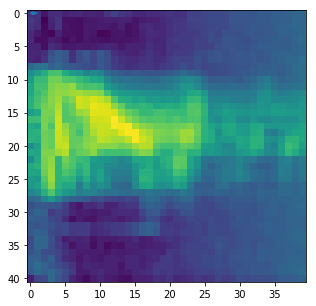

In [11]:
#new_result = logfbank()
#new_result = one_mfsc(audio, 20000, None, 41, 40).T #Hop size is unnecessary but kept for security.
#sample_rate=20000

interesting = mat['train_samples'][1,0]
audio = [item for sublist in interesting for item in sublist]

samplerate = 20000
duration = len(interesting)/samplerate
print(duration)
number_of_rows = 41
winstep = duration/number_of_rows
print(winstep)
new_result = logfbank(interesting , samplerate = samplerate , winlen = 2 * winstep, winstep = winstep, nfilt=40, nfft=1024)


#testing = 1
plt.figure(figsize=(5,5))
plt.plot(np.linspace(0, len(interesting) / samplerate, num=len(interesting)), audio)
plt.imshow(new_result, aspect='auto', origin='lower');
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])

In [ ]:
print(len(results[0][0]))
print('hey')

[0.00024414]


(40.5, -0.5)

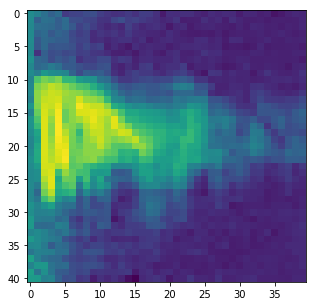

In [12]:
#This is to inspect images from the results.
#original_samples = mat['train_samples'][:,0]
#original_audios = [item for aud in original_samples for item in aud]
print(original_audios[0])

plt.figure(figsize=(5,5))
plt.plot(np.linspace(0, len(original_audios[0]) / 20000, num=len(original_audios[0])), original_audios[0])
plt.imshow(results[0].T, aspect='auto', origin='lower');
ax = plt.gca()
ax.set_ylim(ax.get_ylim()[::-1])